In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from matplotlib import font_manager, rc, dates
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.3.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 921228027433323512
]


In [3]:
def reward_co2(co2):
    reward = np.exp(-((co2-900)**2)/(2*350**2))
    return reward


def reward_heat(temp):
    reward = np.exp(-((temp-29)**2)/(2*2**2))
    return reward

* 학습용 데이터셋 준비(솜사탕)
* 거실만사용
* 환기, 보일러작동 2개로 멀티에이전트 학습

In [4]:
## 불러오기 ##
path = os.getcwd()
site_list = sorted(glob(os.path.join(path,"data","sensing_data","*")))
site_list = list(map(os.path.basename,site_list))
print(path)
print(site_list)
site = "솜사탕"
time_mean = "5T"
csv_by_site_det = []


structure = sorted(glob(os.path.join(path,"data","sensing_data",site,'*')))
structure = list(map(os.path.basename,structure))
for j in structure:
        temp_data = dd.read_csv(os.path.join(path,"data","sensing_data",site,j),encoding='cp949').compute()
        temp_data['T/D'] = pd.to_datetime(temp_data['T/D'])
       
        temp_data.set_index('T/D',inplace=True)
        temp_data = temp_data.resample(time_mean,).mean()
        temp_data['site_details'] = j
        csv_by_site_det.append(temp_data)

data = pd.concat(csv_by_site_det)
data.columns = ['index','temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']
data = data[['temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']]
## 라벨링 ##

data['vent'] = 0
data['people'] = 0
data['heat'] = 0


data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['heat']] = 1

#0부터 월요일
data.loc[data[data.index.dayofweek == 5].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 5].index,['people']] = 0
data.loc[data[data.index.dayofweek == 5].index,['heat']] = 0

data.loc[data[data.index.dayofweek == 6].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 6].index,['people']] = 0
data.loc[data[data.index.dayofweek == 6].index,['heat']] = 0



c:\Users\Go\OneDrive - UOS\allrepos\multi_agent_awac
['남부', '동화나라', '소리엘', '솜사탕', '예나']


In [5]:
room_list = ['솜사탕_거실.csv', '솜사탕_방1.csv','솜사탕_방2.csv','솜사탕_방3.csv','솜사탕_방4.csv','솜사탕_부엌.csv',]
data_by_room = {}
data_room = data.loc[:,['temp','co2','site_details','vent','heat','people']]

for i in room_list:
    room_name = i
    dataset = data_room.loc[data_room.site_details == room_name,:][['temp','co2','vent','heat','people']]

    dataset.loc[:,'co2_t+1'] = dataset.loc[:,'co2'].shift(-1)
    dataset.loc[:,'temp_t+1'] = dataset.loc[:,'temp'].shift(-1)
    dataset.loc[:,'people_t+1'] = dataset.loc[:,'people'].shift(-1)
    dataset.loc[:,'reward_co2'] = dataset.loc[:,'co2_t+1'].map(lambda x : reward_co2(x))
    dataset.loc[:,'reward_heat'] = dataset.loc[:,'temp_t+1'].map(lambda x : reward_heat(x))
    dataset.loc[:,'done'] = False
    dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
    dataset = dataset.iloc[:-1,:]
    #데이터셋 추가
    data_by_room[i] = dataset.loc[:,:][['co2','temp','people','co2_t+1','temp_t+1','people_t+1','reward_co2','reward_heat','vent','heat','done',]]



In [6]:
data_by_room[room_list[1]]

,co2,temp,people,co2_t+1,temp_t+1,people_t+1,reward_co2,reward_heat,vent,heat,done
T/D,,,,,,,,,,,
2021-12-29 17:15:00,950.867765,16.399176,0,991.816033,19.465100,0.0,0.966176,0.000012,1,0,False
2021-12-29 17:20:00,991.816033,19.465100,0,1035.277933,22.146367,0.0,0.928027,0.002819,1,0,False
2021-12-29 17:25:00,1035.277933,22.146367,0,1070.793267,23.506767,0.0,0.887752,0.023007,1,0,False
2021-12-29 17:30:00,1070.793267,23.506767,0,1071.176833,24.381400,0.0,0.887277,0.069500,1,0,False
2021-12-29 17:35:00,1071.176833,24.381400,0,1067.187833,24.774083,0.0,0.892179,0.107282,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-10 16:30:00,1376.824600,27.100933,0,1279.189433,27.111667,0.0,0.556062,0.640360,1,0,False
2022-03-10 16:35:00,1279.189433,27.111667,0,1282.804833,26.994767,0.0,0.549844,0.604944,1,0,False
2022-03-10 16:40:00,1282.804833,26.994767,0,1251.916100,26.859667,0.0,0.603210,0.564041,1,0,False


array([[<AxesSubplot:title={'center':'reward_co2'}>,
        <AxesSubplot:title={'center':'reward_heat'}>]], dtype=object)

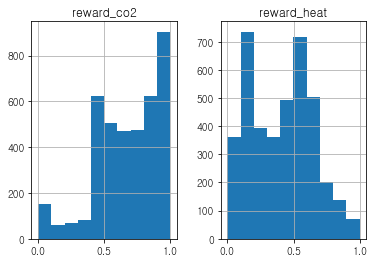

In [7]:
data_by_room[room_list[1]][['reward_co2','reward_heat']].hist()

Wall time: 392 ms


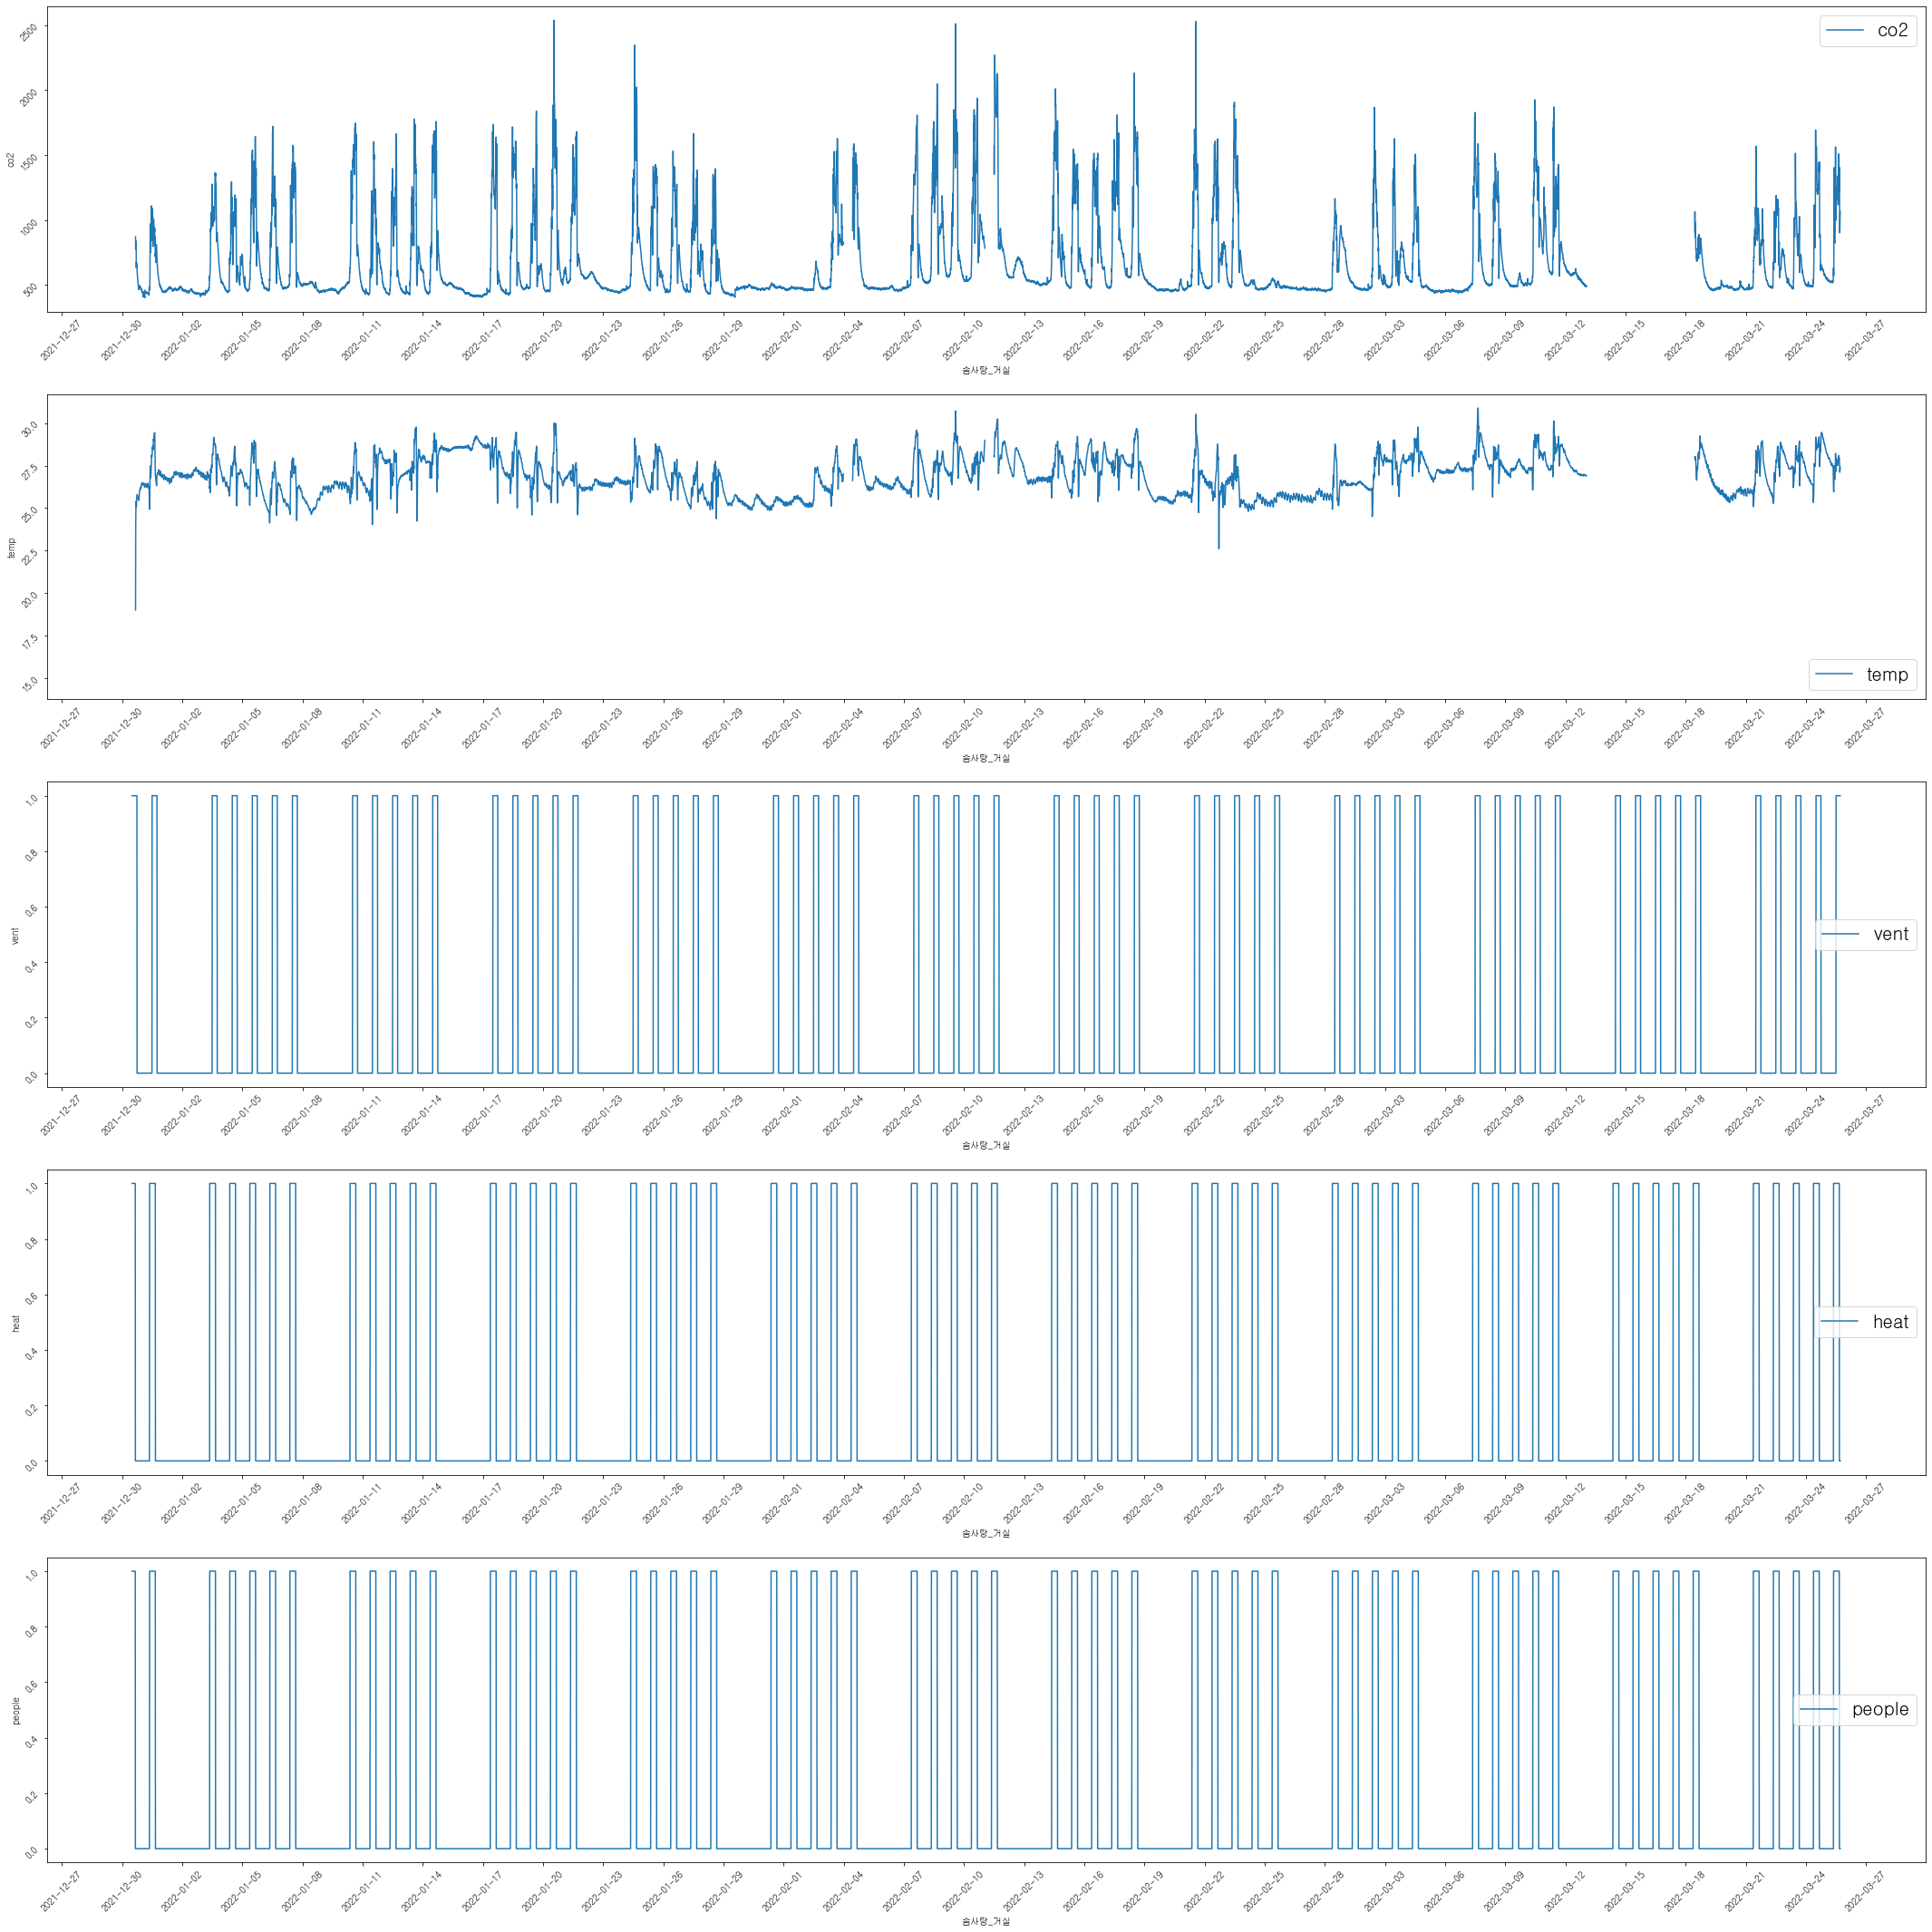

In [8]:
%%time
fig, axes = plt.subplots(5,1, figsize=(30,30))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)


p_data = data_by_room["솜사탕_거실.csv"]


axes[0].plot(p_data['co2'], label = 'co2')
axes[0].set_ylabel('co2')
axes[0].legend()
axes[0].set_xlabel("솜사탕_거실")
axes[0].tick_params(labelrotation=45)
axes[0].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[1].plot(p_data['temp'], label = 'temp')
axes[1].set_ylabel('temp')
axes[1].legend()
axes[1].set_xlabel("솜사탕_거실")
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[2].plot(p_data['vent'], label = 'vent')
axes[2].set_ylabel('vent')
axes[2].legend()
axes[2].set_xlabel("솜사탕_거실")
axes[2].tick_params(labelrotation=45)
axes[2].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[3].plot(p_data['heat'], label = 'heat')
axes[3].set_ylabel('heat')
axes[3].legend()
axes[3].set_xlabel("솜사탕_거실")
axes[3].tick_params(labelrotation=45)
axes[3].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[4].plot(p_data['people'], label = 'people')
axes[4].set_ylabel('people')
axes[4].legend()
axes[4].set_xlabel("솜사탕_거실")
axes[4].tick_params(labelrotation=45)
axes[4].xaxis.set_major_locator(dates.DayLocator(interval=3,))

fig.tight_layout()

Wall time: 124 ms


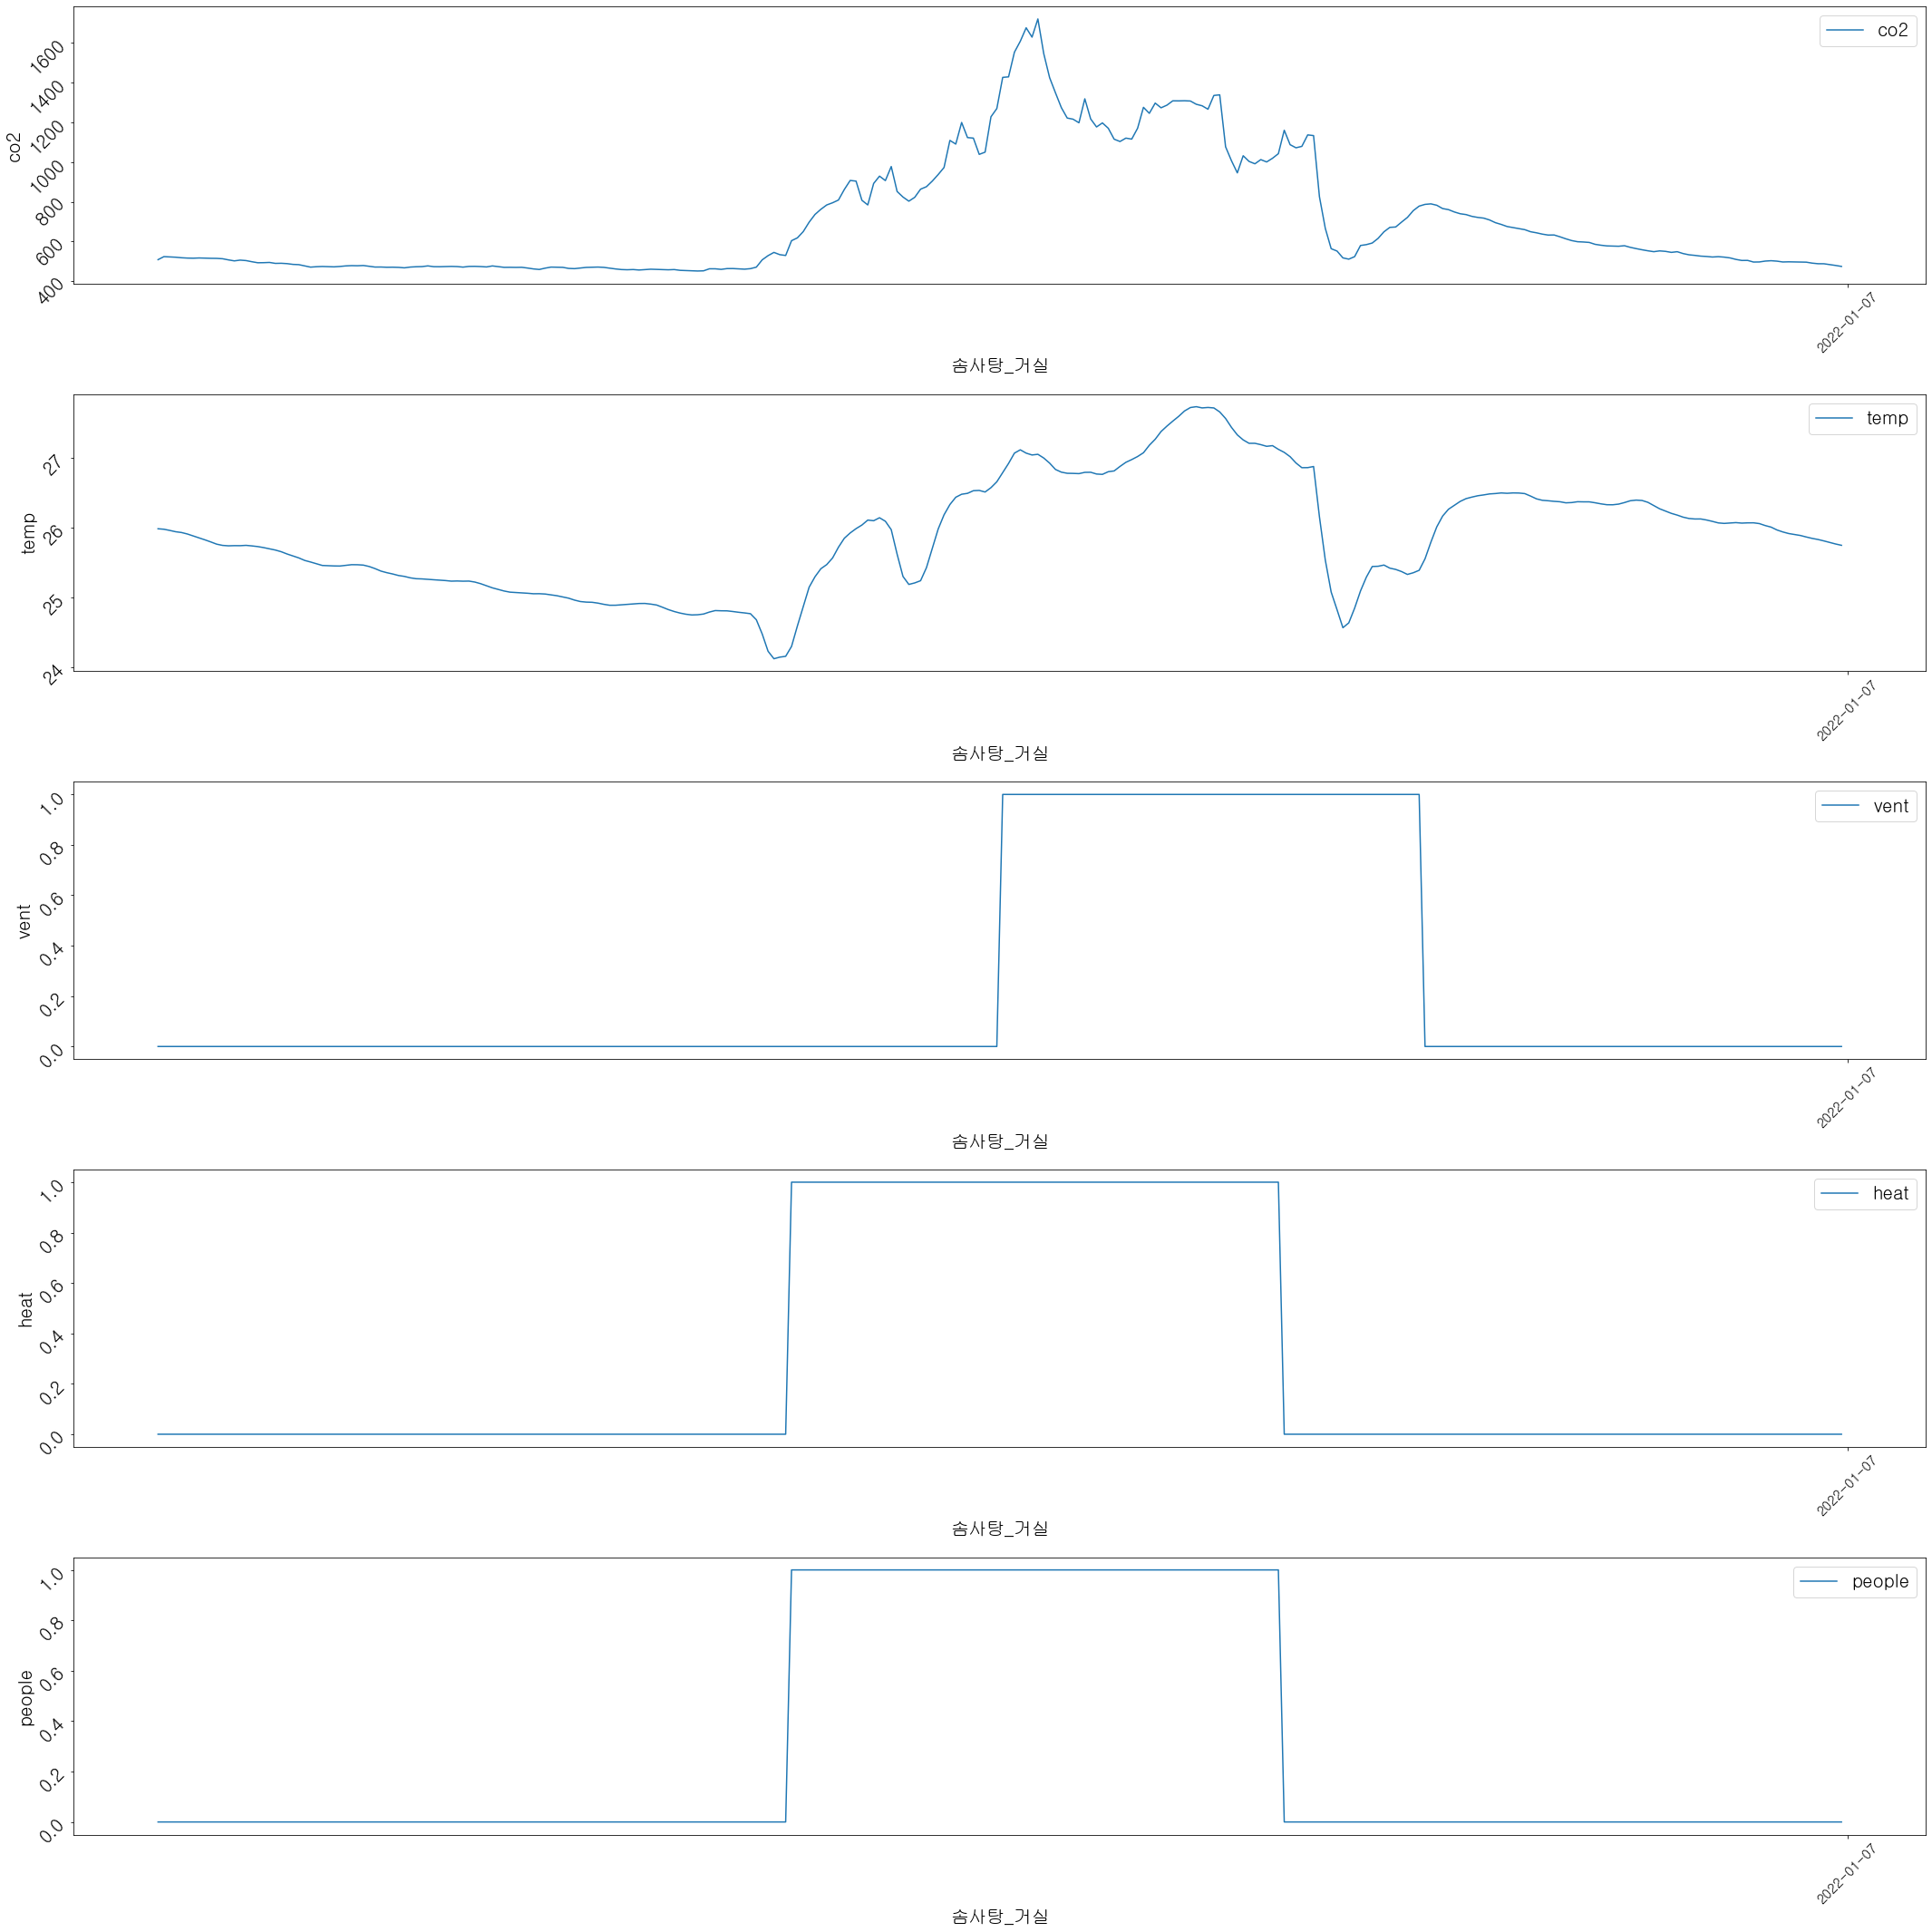

In [9]:
%%time
fig, axes = plt.subplots(5,1, figsize=(30,30))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)


p_data = data_by_room["솜사탕_거실.csv"].loc['2022-01-6':'2022-01-06']

axes[0].plot(p_data['co2'], label = 'co2')
axes[0].set_ylabel('co2')
axes[0].legend()
axes[0].set_xlabel("솜사탕_거실")
axes[0].tick_params(labelrotation=45)
axes[0].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[1].plot(p_data['temp'], label = 'temp')
axes[1].set_ylabel('temp')
axes[1].legend()
axes[1].set_xlabel("솜사탕_거실")
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[2].plot(p_data['vent'], label = 'vent')
axes[2].set_ylabel('vent')
axes[2].legend()
axes[2].set_xlabel("솜사탕_거실")
axes[2].tick_params(labelrotation=45)
axes[2].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[3].plot(p_data['heat'], label = 'heat')
axes[3].set_ylabel('heat')
axes[3].legend()
axes[3].set_xlabel("솜사탕_거실")
axes[3].tick_params(labelrotation=45)
axes[3].xaxis.set_major_locator(dates.DayLocator(interval=3,))

axes[4].plot(p_data['people'], label = 'people')
axes[4].set_ylabel('people')
axes[4].legend()
axes[4].set_xlabel("솜사탕_거실")
axes[4].tick_params(labelrotation=45)
axes[4].xaxis.set_major_locator(dates.DayLocator(interval=3,))

fig.tight_layout()

* 멀티에이전트 학습용 함수

In [10]:
# dense model 만드는 함수
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

# multi_agent structure 만드는 함수
def build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape):
    actor_list = []
    critic_qnet_list = []
    critic_qnet_target_list = []
    for i in range(agent_num):
        actor_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_target_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
    return actor_list, critic_qnet_list, critic_qnet_target_list


def get_action(actor,state, num_samples: int = 3):
    logit_sam = actor(state)
    m = tfp.distributions.Categorical(logits = logit_sam)
    return tf.reshape(m.sample(num_samples),[-1,num_samples])

def get_mean_qsa(qs,sampled_as):
    
    mean_q = tf.concat([tf.reshape(tf.gather(qs[i],sampled_as[i], axis=0),[1,-1]) for i in range(len(qs))],axis=0)
    mean_q = tf.math.reduce_mean(mean_q,axis=1,keepdims=True)
    return mean_q

* tf.float32 방식

In [77]:
%%time
room_sync_list = ['솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv', '솜사탕_거실.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']

s = []
ns = []
a_list = []
r_list = []

start_date = '2022-01-04'
end_date = '2022-01-27'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index




temp_data = data_by_room[i].loc[row_ind]

s.append(tf.convert_to_tensor(temp_data.values[:,[0,],],dtype=tf.float32))
ns.append(tf.convert_to_tensor(temp_data.values[:,[3,],],dtype=tf.float32))

a_list.append(tf.convert_to_tensor(temp_data.values[:,[8],],dtype=tf.int64))
a_list.append(tf.convert_to_tensor(temp_data.values[:,[9],],dtype=tf.int64))


r_list.append(tf.convert_to_tensor(temp_data.values[:,[6],],dtype=tf.float32))
r_list.append(tf.convert_to_tensor(temp_data.values[:,[7],],dtype=tf.float32))

print(temp_data.isna().sum())
#정규화 레이어
# layer = tf.keras.layers.Normalization(axis=1)
# layer.adapt(s[0])

#데이터셋 제작
# s_dataset = tf.data.Dataset.from_tensor_slices(layer(s[0]))
# ns_dataset = tf.data.Dataset.from_tensor_slices(layer(ns[0]))
s_dataset = tf.data.Dataset.from_tensor_slices(tf.keras.utils.normalize(s[0], axis=0, order=0))
ns_dataset = tf.data.Dataset.from_tensor_slices(tf.keras.utils.normalize(ns[0], axis=0, order=0))

a1_dataset = tf.data.Dataset.from_tensor_slices(a_list[0])
a2_dataset = tf.data.Dataset.from_tensor_slices(a_list[1])

r1_dataset = tf.data.Dataset.from_tensor_slices(r_list[0])
r2_dataset = tf.data.Dataset.from_tensor_slices(r_list[1])

done_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data_by_room[i].loc[start_date:end_date].values[:,[10]],dtype=tf.float32))

train_dataset = tf.data.Dataset.zip((s_dataset, ns_dataset, ((a1_dataset,r1_dataset),(a2_dataset,r2_dataset),),done_dataset))
# train_dataset.element_spec

#################set params!################
# params of multi_AWAC
agent_num = 2
state_len = 1
hidden_structure= [64, 128, 256, 128, 64]
input_shape= 1
output_shape= 2
act_function= 'relu'
lam = 1
optimizer= keras.optimizers.Adam(learning_rate=0.001)
gamma= 0.9
tau = 0.1
num_action_samples = 8
loss_fun = tf.keras.losses.MeanSquaredError()

# 학습 루프 관련
batch_size = 512
buffer_len = len(train_dataset)
# n_train = 10
n_run = 100
############################################
# 초기 모델 생성
actor_list, critic_qnet_list, critic_qnet_target_list = build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape)


# #배치셋 생성
# batched_dataset = train_dataset.shuffle(buffer_size=buffer_len).batch(batch_size, drop_remainder=True)
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

# 트레인 루프
# for batch in batched_dataset.take(n_train):
critic_loss = []
actor_loss = []

actor = actor_list[0]
critic_qnet = critic_qnet_list[0]
critic_qnet_target = critic_qnet_target_list[0]

critic_qnet_target.set_weights(critic_qnet.get_weights()) 





count = 0
for batch in shuffled_dataset.batch(batch_size).take(1).repeat(n_run):
    count += 1
    if count % 1 == 0:
        print(f"-run- [{count}]/[{n_run}]")
    
    with tf.GradientTape() as t:
        ##데이터 
        s = batch[0]
        ns = batch[1]
        a = batch[2][0][0]
        r = batch[2][0][1]
        done = batch[3]
        
        ##로스 계산
        qs = critic_qnet_target(ns)
        sampled_as = get_action(actor,ns, num_action_samples)
        mean_qsa = get_mean_qsa(qs,sampled_as)
        q_target = r + gamma * mean_qsa * (1 - done)

        # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
        q_val = tf.concat([tf.reshape(tf.gather(critic_qnet(s)[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
        loss = loss_fun(q_val, q_target)

    critic_loss.append(loss)    
    grads = t.gradient(loss, critic_qnet.trainable_variables)

    for q in range(1):
        # qnet 업데이트
        # qnet_weights = critic_qnet_weight_list[q]
        # qnet_target_weights = critic_qnet_target_weight_list[q]
        # grad = grads[q]
        optimizer.apply_gradients(zip(grads, critic_qnet.trainable_variables))
        # target net 업데이트
        new_target_weights = []
        for p, target_weights in enumerate(critic_qnet_target.trainable_variables):
            qnet_weights_s = critic_qnet.trainable_variables[p]
            updated_target_weights_s = target_weights*(1 - tau) + qnet_weights_s*tau
            new_target_weights.append(updated_target_weights_s)
        critic_qnet_target.set_weights(new_target_weights)

        #타겟네트워크까지 업데이트한 후 actor net 업데이트
        with tf.GradientTape() as tp:
            # log_probability 계산
            logits = actor(s)
            m = tfp.distributions.Categorical(logits = logits)
            log_prob = tf.reshape(m.log_prob(a.numpy().squeeze()),[-1,1])

            #가중치항 계산
            qs = critic_qnet_target(s)
            action_probs = tf.nn.softmax(logits, axis=None, name=None)
            vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
            qas = tf.concat([tf.reshape(tf.gather(qs[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            adv = qas - vs
            weight_term = tf.math.exp((1/lam*adv), name=None)
            
            

            #loss
            loss = tf.math.reduce_mean(log_prob * weight_term*-1)
        actor_grad = tp.gradient(loss, actor.trainable_variables)
        actor_loss.append(loss)
        print(actor_grad[0])
        optimizer.apply_gradients(zip(actor_grad, actor.trainable_variables))


co2            0
temp           0
people         0
co2_t+1        0
temp_t+1       0
people_t+1     0
reward_co2     0
reward_heat    0
vent           0
heat           0
done           0
dtype: int64
-run- [1]/[100]
tf.Tensor(
[[-1.9185875e-03  0.0000000e+00  1.1232358e-03  0.0000000e+00
  -2.6227228e-04  1.4178030e-03  0.0000000e+00  0.0000000e+00
  -9.6347649e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -5.2229199e-04  7.0682296e-04 -9.3103683e-04
  -1.5750733e-03  0.0000000e+00  0.0000000e+00  1.3160775e-03
   0.0000000e+00 -2.0125112e-03  1.4541498e-03  2.5615533e-04
  -4.3956519e-04 -1.3343765e-06 -5.7754427e-04  0.0000000e+00
  -1.3263382e-03  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.2985681e-03  0.0000000e+00  2.5702592e-03 -1.3672631e-03
   0.0000000e+00  5.9438584e-04 -3.2746111e-04  1.0697196e-03
   5.8908906e-04  0.0000000e+00  2.6842086e-03  1.4063829e-03
   0.0000000e+00  0.0000000e+00 -9.9344202e-04  0.0000000e+00
   0.0000000e+00  1.5027844e-

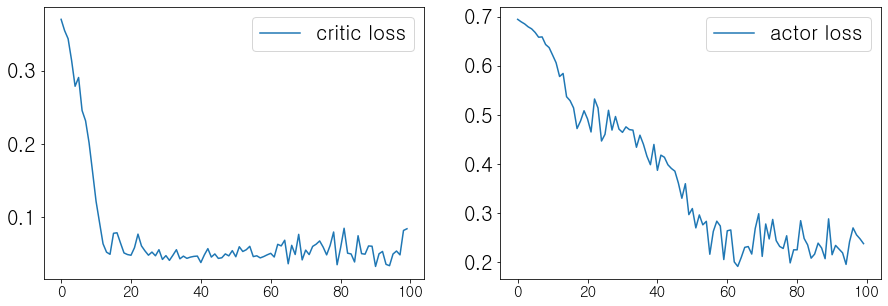

In [78]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(critic_loss, label='critic loss')
axes[0].legend()
axes[1].plot(actor_loss, label='actor loss')
axes[1].legend()

In [79]:
room_sync_list = ['솜사탕_거실.csv']


s = []

start_date = '2022-02-21'
end_date = '2022-02-24'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index


# attention state set 제작
test_action_set_list = []

temp_data = data_by_room['솜사탕_거실.csv'].loc[row_ind]
test_action_set_list.append(temp_data)
s.append(tf.convert_to_tensor(temp_data.values[:,[0,],],dtype=tf.float32))
    
    

s = tf.concat(s,axis=1)

# state-action set 제작
testset_action = actor_list[0](tf.keras.utils.normalize(s, axis=0, order=0))
test_action_set_list[0]['testset_a_vent'] = tf.math.argmax(testset_action,axis=1,output_type=tf.dtypes.int64,name=None).numpy()


Wall time: 57.7 ms


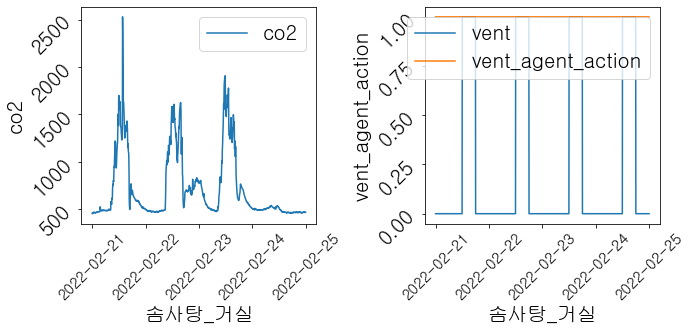

In [80]:
%%time
fig, axes = plt.subplots(1,2, figsize=(10,5))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)


p_data = test_action_set_list[0]

axes[0].plot(p_data.loc[:,'co2'], label = 'co2')
axes[0].set_ylabel('co2')
axes[0].legend()
axes[0].set_xlabel('솜사탕_거실')
axes[0].tick_params(labelrotation=45)
axes[0].xaxis.set_major_locator(dates.DayLocator())


axes[1].plot(p_data.loc[:,'vent'], label = 'vent')
axes[1].set_ylabel('vent')
axes[1].legend()
axes[1].set_xlabel('솜사탕_거실')
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator())

axes[1].plot(p_data.loc[:,'testset_a_vent'], label = 'vent_agent_action')
axes[1].set_ylabel('vent_agent_action')
axes[1].legend()
axes[1].set_xlabel('솜사탕_거실')
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator())


plt.tight_layout()